In [35]:
import os
import json
import matplotlib.pyplot as plt

def find_json_files(base_dir):
    """Recursively find all JSON files in a directory."""
    json_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

def extract_folder_name(file_path, base_dir):
    """Extract the first folder name relative to the base directory."""
    relative_path = os.path.relpath(file_path, base_dir)
    first_folder = relative_path.split(os.sep)[0]  # Get the first folder in the path
    return first_folder

def read_json(file_path):
    """Read and return the content of a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    losses = data.get("losses", [])
    accuracies = data.get("accuracies", [])
    plasticity_per_task = data.get("plasticity_per_task", [])
    return {
        "accuracies": accuracies,
        "plasticity_per_task": plasticity_per_task
    }

def compute_averages(json_files, base_dir):
    """Compute the average accuracy and plasticity for each folder."""
    averages = {}
    
    for json_file in json_files:
        folder_name = extract_folder_name(json_file, base_dir)
        data = read_json(json_file)
        accuracies = data.get("accuracies", [])
        plasticity_per_task = data.get("plasticity_per_task", [])
        
        # Compute averages
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0
        avg_plasticity = sum(plasticity_per_task) / len(plasticity_per_task) if plasticity_per_task else 0
        
        averages[folder_name] = {
            "average_accuracy": avg_accuracy,
            "average_plasticity": avg_plasticity
        }
    
    return averages

def print_averages(averages):
    """Print the average accuracy and plasticity for each folder."""
    print(f"{'Approach':<20}{'Average Accuracy':<20}{'Average Plasticity':<20}")
    print("-" * 60)
    for approach, metrics in averages.items():
        avg_accuracy = metrics["average_accuracy"]
        avg_plasticity = metrics["average_plasticity"]
        print(f"{approach:<20}{avg_accuracy:<20.4f}{avg_plasticity:<20.4f}")

def plot_aggregated_data(json_files, base_dir, metric):
    """Aggregate and plot loss values from all JSON files in one graph."""
    plt.figure(figsize=(10, 6))
    
    for json_file in json_files:
        folder_name = extract_folder_name(json_file, base_dir)
        data = read_json(json_file)
        values = data.get(metric, [])
        
        if isinstance(values, list) and values:  # Check if accuracies are valid
            plt.plot(values, label=folder_name, linewidth=1)
    
    plt.title(metric + " from all approaches")
    plt.xlabel("Tasks")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(title="Folder Name")
    plt.show()

def plot_zoomed_data(json_files, base_dir, metric, num_tasks=150, accuracy_range=(0.0, 1.0)):
    """
    Plot a zoomed-in graph for the last num_tasks and focus on a specific accuracy range.
    """
    plt.figure(figsize=(10, 6))
    
    for json_file in json_files:
        folder_name = extract_folder_name(json_file, base_dir)
        data = read_json(json_file)
        values = data.get(metric, [])
        
        if isinstance(values, list) and len(values) > num_tasks:  # Ensure there are enough tasks
            # Only plot if at least one value is within the accuracy range
            last_values = values[-num_tasks:]
            if any(accuracy_range[0] <= v <= accuracy_range[1] for v in last_values):
                plt.plot(range(len(values))[-num_tasks:], last_values, label=folder_name, linewidth=1)
    
    
    plt.title(f"{metric} (Zoomed: Last {num_tasks} Tasks)")
    plt.xlabel("Tasks")
    plt.ylabel(metric)
    plt.xlim(len(values) - num_tasks, len(values))  # Focus on the last num_tasks
    plt.ylim(accuracy_range)  # Focus on the specified accuracy range
    plt.grid()
    plt.legend(title="Folder Name")
    plt.show()


In [37]:
def main(base_dir):
    """Main function to process files and plot aggregated data."""
    json_files = find_json_files(base_dir)
    # Plot aggregated data
    plot_aggregated_data(json_files, base_dir, "accuracies")
    plot_aggregated_data(json_files, base_dir, "plasticity_per_task")

    # Plot zoomed-in graph
    plot_zoomed_data(json_files, base_dir, "accuracies", accuracy_range=(0.51, 0.67))
    plot_zoomed_data(json_files, base_dir, "plasticity_per_task", accuracy_range=(0.4, 0.54))

    # Compute and print averages
    averages = compute_averages(json_files, base_dir)
    print_averages(averages)


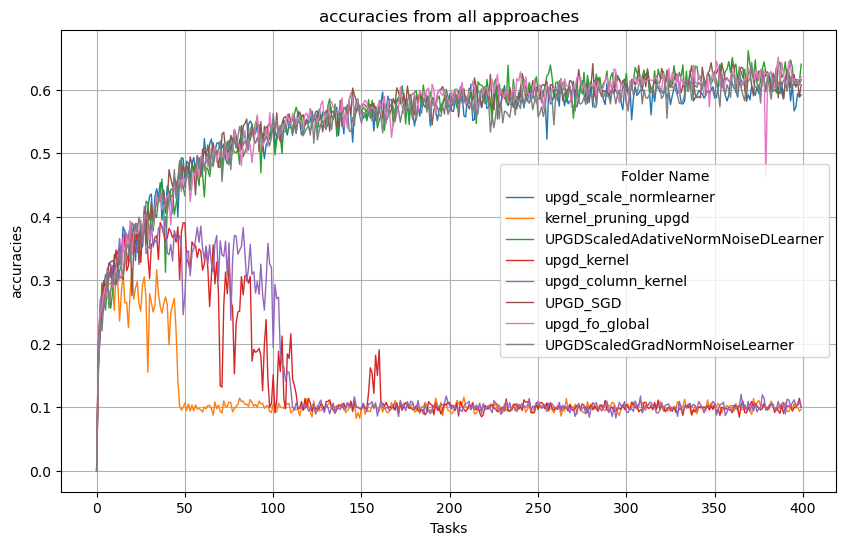

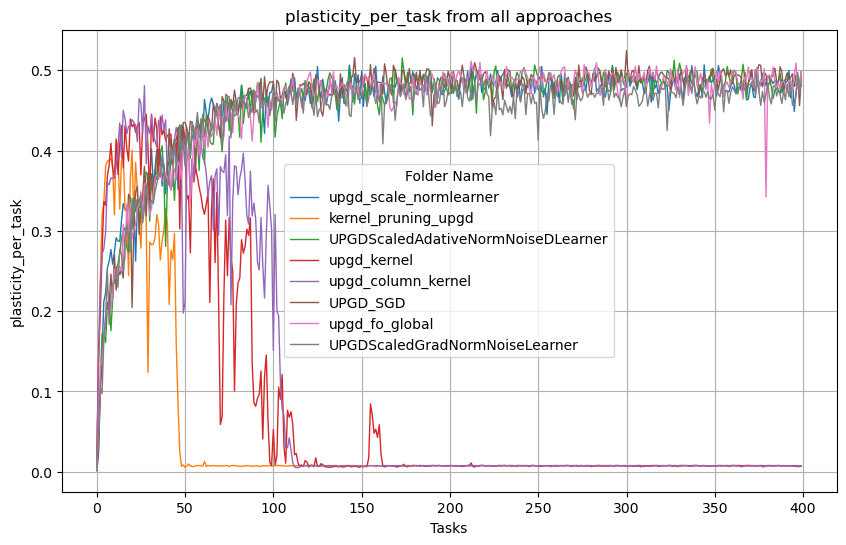

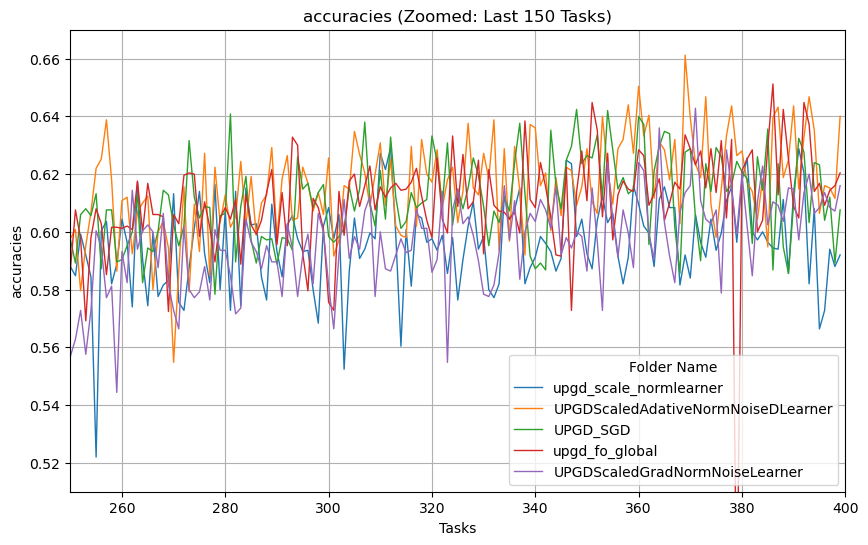

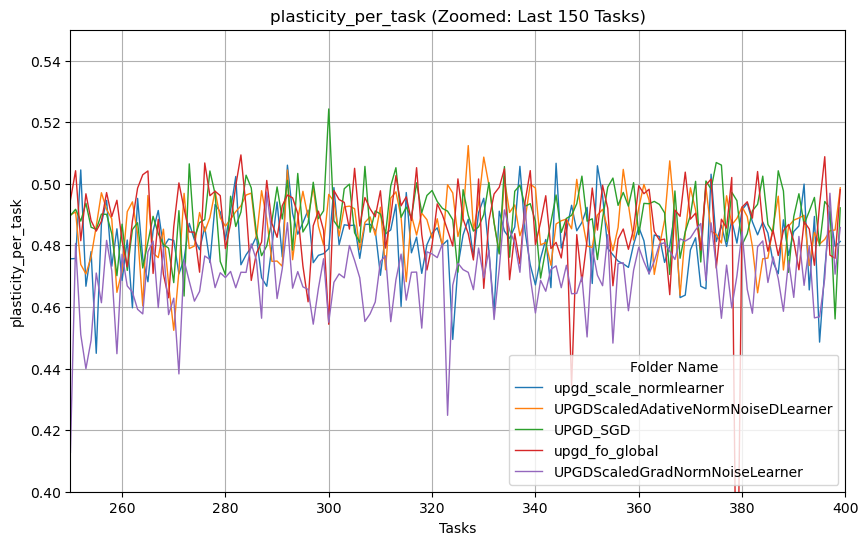

Approach            Average Accuracy    Average Plasticity  
------------------------------------------------------------
upgd_scale_normlearner0.5462              0.4554              
kernel_pruning_upgd 0.1185              0.0421              
UPGDScaledAdativeNormNoiseDLearner0.5530              0.4548              
upgd_kernel         0.1529              0.0859              
upgd_column_kernel  0.1614              0.0995              
UPGD_SGD            0.5538              0.4594              
upgd_fo_global      0.5529              0.4542              
UPGDScaledGradNormNoiseLearner0.5427              0.4439              


In [38]:
# Example usage
base_dir = "logs/label_permuted_cifar10_stats"  # Replace with the path to your logs directory
main(base_dir)